In [1]:
import numpy as np, pandas as pd
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import  (roc_auc_score, average_precision_score, f1_score, accuracy_score,
    precision_score, recall_score, classification_report, roc_curve, precision_recall_curve, confusion_matrix)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from scipy.stats import randint, uniform, loguniform

In [2]:
# 정규화 이전
data = pd.read_csv("users_prep.csv", index_col=0)
data = data.dropna()

all_cols = data.columns.tolist()
first14_cols = all_cols[:14] + all_cols[-1:]
data = data[first14_cols].copy()

X = data.drop(columns=['id', 'fraud_risk', 'birth_month', 'longitude', 'latitude', 'address'])
y = data['fraud_risk']
data.head()

,id,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,fraud_risk
0,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,29278,59696,127613,787,5,1
1,1746,53,68,1966,12,Female,3606 Federal Boulevard,40.76,-73.74,37891,77254,191349,701,5,1
2,1718,81,67,1938,11,Female,766 Third Drive,34.02,-117.89,22681,33483,196,698,5,1
3,708,63,63,1957,1,Female,3 Madison Street,40.71,-73.99,163145,249925,202328,722,4,1
4,1164,43,70,1976,9,Male,9620 Valley Stream Drive,37.76,-122.44,53797,109687,183855,675,1,0


In [24]:
y.value_counts(normalize=True)

fraud_risk
1    0.674323
0    0.325677
Name: proportion, dtype: float64

In [3]:
# # 1차 정규화
# data = pd.read_csv("users_prep_FE1.csv", index_col=0)
# data = data.dropna()

# all_cols = data.columns.tolist()
# first14_cols = all_cols[:32] + all_cols[-1:]
# data = data[first14_cols].copy()

# X = data.drop(columns=['id', 'fraud_count', 'fraud_risk', 'birth_month', 'longitude', 'latitude',
#                        'W_avg_min_amount', 'W_avg_max_amount', 'W_avg_mean_amount', 'address', 
#                        'W_avg_median_amount', 'W_avg_count_transaction',])
# y = data['fraud_risk']
# data.head()

In [4]:
# # 2차 정규화
# data = pd.read_csv("users_prep_FE2.csv", index_col=0)
# data = data.dropna()
# X = data.drop(columns=['id', 'fraud_count', 'fraud_risk', 'birth_month', 'longitude', 'latitude',
#                        'W_avg_min_amount', 'W_avg_max_amount', 'W_avg_mean_amount', 'address', 
#                        'W_avg_median_amount', 'W_avg_count_transaction',])
# y = data['fraud_risk']
# data.head()

In [5]:
cat_cols = X.select_dtypes(include=["object","category"]).columns.tolist()
num_cols = X.columns.difference(cat_cols).tolist()

preprocess = ColumnTransformer([("num", StandardScaler(), num_cols),
                                ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop='first'), cat_cols)])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

### Logistic / RF / GB / SVM / KNN / XGBoost / LGBM 

In [7]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=5000, class_weight="balanced", 
                                             solver="lbfgs", random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=500, class_weight="balanced", 
                                           n_jobs=-1, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "SVM_RBF": SVC(kernel="rbf", probability=True, class_weight="balanced", C=1.0, 
                   gamma="scale", random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=15, weights="distance"),
    "XGBoost": XGBClassifier(n_estimators=1000, max_depth=10, learning_rate=0.05, subsample=0.8, 
                             colsample_bytree=0.8, objective="binary:logistic", 
                             eval_metric="logloss", n_jobs=-1, random_state=42),
    "LGBM": LGBMClassifier(n_estimators=1000, num_leaves=63, learning_rate=0.05, subsample=0.8, 
                           colsample_bytree=0.8, class_weight="balanced", n_jobs=-1, random_state=42, verbose=-1)
    }

#### 학습 결과

In [8]:
pipes = {}  

for name, clf in models.items():
    pipe = Pipeline([("prep", preprocess), ("clf", clf)])
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    pipes[name] = pipe  

    print("\n", "="*20, f"{name}", "="*20)
    print(classification_report(y_test, pred, digits=4))


 ==================== LogisticRegression ====================
              precision    recall  f1-score   support

           0     0.4160    0.6582    0.5098        79
           1     0.7731    0.5576    0.6479       165

    accuracy                         0.5902       244
   macro avg     0.5946    0.6079    0.5788       244
weighted avg     0.6575    0.5902    0.6032       244


 ==================== RandomForest ====================
              precision    recall  f1-score   support

           0     0.3750    0.1899    0.2521        79
           1     0.6863    0.8485    0.7588       165

    accuracy                         0.6352       244
   macro avg     0.5306    0.5192    0.5055       244
weighted avg     0.5855    0.6352    0.5948       244


 ==================== GradientBoosting ====================
              precision    recall  f1-score   support

           0     0.3864    0.2152    0.2764        79
           1     0.6900    0.8364    0.7562       165

 

#### 중요도가 큰 피처

- table / 수평 막대 그래프 : 각 모델마다 중요도가 큰 상위 20개 피처
  - feature: 전처리(One-Hot 포함) 이후의 실제 피처 이름
  - importance: 모델이 판단한 상대적 중요도 값
- RandomForest / GradientBoosting / XGBoost / LGBM
  - feature_importances_를 사용(보통 분기/손실 감소 기여도)
  - 값이 클수록 그 피처가 결정나무 분할에서 더 자주, 더 크게 성능 향상에 기여했다는 뜻
- LogisticRegression
  - |coef_|(계수의 절댓값)을 중요도로 사용
  - coef_signed가 양수면 사기일 확률을 올리는 방향, 음수면 내리는 방향. 크기가 클수록 영향 큼
- SVM_RBF / KNN
  - 고유 중요도가 없어서 Permutation importance로 근사(스코어는 average_precision)
  - 해당 피처를 랜덤 섞었을 때 PR-AUC가 얼마나 떨어지는지의 평균 기여를 수치화

In [9]:
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from scipy import sparse

def _is_fitted_ct(ct):
    return hasattr(ct, "transformers_")

def _to_dense_shape(Xt):
    if sparse.issparse(Xt):
        return Xt.shape[1]
    return Xt.shape[1]

def safe_feature_names(pipe, X_train):
    prep = pipe.named_steps.get("prep", None)
    if prep is None:
        return np.array(list(X_train.columns)), len(X_train.columns)
    if not _is_fitted_ct(prep):
        prep.fit(X_train)

    Xt_sample = prep.transform(X_train.iloc[:5])
    n_after = _to_dense_shape(Xt_sample)

    # 1) get_feature_names_out 시도
    try:
        fn = prep.get_feature_names_out(X_train.columns)
        fn = np.asarray(fn, dtype=object)
        if len(fn) == n_after:
            return fn, n_after
    except Exception:
        pass

    # 2) 서브 변환기에서 끌어오기 (가능하면)
    try:
        names = []
        for name, trans, cols in prep.transformers_:
            if name == "remainder" and trans == "drop":
                continue
            if trans == "passthrough":
                # 선택된 컬럼명이 문자열이면 그대로, 인덱스면 X_train에서 매핑
                if isinstance(cols[0], (str, np.str_)):
                    names.extend(list(cols))
                else:
                    names.extend(list(X_train.columns[cols]))
            else:
                # 원-핫 등: 하위 변환기가 get_feature_names_out 지원하면 사용
                if hasattr(trans, "get_feature_names_out"):
                    base = cols if isinstance(cols, (list, np.ndarray, pd.Index)) else np.array(cols)
                    # base가 인덱스(정수)면 실제 컬럼명으로 바꿔줌
                    if len(base) > 0 and isinstance(base[0], (int, np.integer)):
                        base = np.array(list(X_train.columns[base]))
                    sub_names = trans.get_feature_names_out(base)
                    names.extend(list(sub_names))
                else:
                    # 이름을 만들 수 없으면 개수만 맞춤
                    Xt_part = trans.transform(X_train[cols]) if isinstance(cols[0], str) else trans.transform(X_train.iloc[:, cols])
                    names.extend([f"{name}__f{i}" for i in range(_to_dense_shape(Xt_part))])
        names = np.asarray(names, dtype=object)
        if len(names) == n_after:
            return names, n_after
    except Exception:
        pass

    # 3) 최종 안전 장치: 개수만 맞춰 f0..f{n-1}
    return np.array([f"f{i}" for i in range(n_after)], dtype=object), n_after

def show_topk(df_imp, title, topk=20):
    if df_imp is None or df_imp.empty:
        print(f"[WARN] {title}: 중요도 계산 불가")
        return
    df_top = df_imp.sort_values("importance", ascending=False).head(topk)
    display(df_top.reset_index(drop=True))
    plt.figure(figsize=(8, max(4, 0.4*len(df_top))))
    plt.barh(df_top.iloc[::-1]["feature"], df_top.iloc[::-1]["importance"])
    plt.title(title)
    plt.tight_layout()
    plt.show()

def importance_df_from_pipe(name, pipe, X_train, y_train, X_test, y_test):
    clf = pipe.named_steps["clf"]
    fn, n_after = safe_feature_names(pipe, X_train)

    # 트리/부스팅 계열
    if hasattr(clf, "feature_importances_") and clf.feature_importances_ is not None:
        vals = np.asarray(clf.feature_importances_, dtype=float)
        # 길이 불일치 시 보정
        if len(vals) != n_after:
            # 차이가 나면 앞쪽/뒤쪽 패딩 or 트렁케이션(최소한 DataFrame 에러는 방지)
            if len(vals) < n_after:
                vals = np.pad(vals, (0, n_after - len(vals)))
            else:
                vals = vals[:n_after]
        return pd.DataFrame({"feature": fn, "importance": vals})

    # 로지스틱
    from sklearn.linear_model import LogisticRegression
    if isinstance(clf, LogisticRegression) and hasattr(clf, "coef_"):
        coefs = np.ravel(clf.coef_)
        if len(coefs) != n_after:
            if len(coefs) < n_after:
                coefs = np.pad(coefs, (0, n_after - len(coefs)))
            else:
                coefs = coefs[:n_after]
        return pd.DataFrame({
            "feature": fn, 
            "importance": np.abs(coefs),
            "coef_signed": coefs
        })

    # 그 외(SVM_RBF, KNN 등): permutation importance (테스트셋 기준, PR-AUC)
    r = permutation_importance(pipe, X_test, y_test, scoring="average_precision",
                               n_repeats=7, random_state=42, n_jobs=-1)
    vals = r.importances_mean
    if len(vals) != n_after:
        if len(vals) < n_after:
            vals = np.pad(vals, (0, n_after - len(vals)))
        else:
            vals = vals[:n_after]
    return pd.DataFrame({"feature": fn, "importance": vals})

# # === 실행: 각 모델 즉시 표시 ===
# for name, pipe in pipes.items():
#     print(f"\n=== {name} — Feature Importance ===")
#     try:
#         imp_df = importance_df_from_pipe(name, pipe, X_train, y_train, X_test, y_test)
#         show_topk(imp_df, f"{name} (Top 20)")
#     except Exception as e:
#         print(f"[ERROR] {name}: {e}")


### 하이퍼파라미터 튜닝 

In [10]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [11]:
models = {
    "LogisticRegression": (LogisticRegression(max_iter=2000, class_weight="balanced", solver="lbfgs", penalty='l2', random_state=42),
                          {"clf__C": loguniform(1e-2, 1e2)}, 25),
    
    "RandomForest": (RandomForestClassifier(class_weight="balanced", n_jobs=-1, random_state=42),
                    {"clf__n_estimators": randint(500, 1500),
                     "clf__max_depth": randint(3, 30),
                     "clf__min_samples_split": randint(2, 20),
                     "clf__min_samples_leaf": randint(1, 10),
                     "clf__max_features": ["sqrt", "log2", None]}, 35),
                     
    "GradientBoosting": (GradientBoostingClassifier(random_state=42),
                        {"clf__n_estimators": randint(300, 1200),
                         "clf__learning_rate": loguniform(0.01, 0.3),
                         "clf__max_depth": randint(2, 6),
                         "clf__subsample": uniform(0.6, 0.4),
                         "clf__min_samples_leaf": randint(1, 20)}, 35),
    
    "SVM_RBF": (SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=42),
               {"clf__C": loguniform(1e-2, 1e3),
                "clf__gamma": loguniform(1e-4, 1e-1)}, 30),
    
    "KNN": (KNeighborsClassifier(),
            {"clf__n_neighbors": randint(3, 61),
             "clf__weights": ["uniform", "distance"],
             "clf__p": [1, 2]}, 30),

    "XGBoost": (XGBClassifier(eval_metric="aucpr", n_jobs=-1, random_state=42),
               {"clf__n_estimators": randint(400, 1500),
                "clf__max_depth": randint(3, 8),
                "clf__learning_rate": loguniform(0.01, 0.2),
                "clf__subsample": uniform(0.6, 0.4),
                "clf__colsample_bytree": uniform(0.5, 0.5),
                "clf__min_child_weight": randint(1, 10),
                "clf__gamma": uniform(0.0, 5.0),
                "clf__reg_alpha": loguniform(1e-8, 1e-1),
                "clf__reg_lambda": loguniform(1e-3, 10.0)}, 40),
    
    "LGBM": (LGBMClassifier(class_weight="balanced", n_jobs=-1, random_state=42, verbose=-1),
            {"clf__n_estimators": randint(600, 2000),
             "clf__num_leaves": randint(31, 255),
             "clf__learning_rate": loguniform(0.02, 0.2),
             "clf__min_child_samples": randint(10, 120),
             "clf__subsample": uniform(0.6, 0.4),
             "clf__colsample_bytree": uniform(0.5, 0.5),
             "clf__reg_lambda": loguniform(1e-3, 10.0),
             "clf__reg_alpha": loguniform(1e-8, 1e-1)}, 40)
    }


LogisticRegression 랜덤서치 시작
Fitting 5 folds for each of 25 candidates, totalling 125 fits
LogisticRegression 랜덤서치 끝

RandomForest 랜덤서치 시작
Fitting 5 folds for each of 35 candidates, totalling 175 fits
RandomForest 랜덤서치 끝

GradientBoosting 랜덤서치 시작
Fitting 5 folds for each of 35 candidates, totalling 175 fits
GradientBoosting 랜덤서치 끝

SVM_RBF 랜덤서치 시작
Fitting 5 folds for each of 30 candidates, totalling 150 fits
SVM_RBF 랜덤서치 끝

KNN 랜덤서치 시작
Fitting 5 folds for each of 30 candidates, totalling 150 fits
KNN 랜덤서치 끝

XGBoost 랜덤서치 시작
Fitting 5 folds for each of 40 candidates, totalling 200 fits
XGBoost 랜덤서치 끝

LGBM 랜덤서치 시작
Fitting 5 folds for each of 40 candidates, totalling 200 fits
LGBM 랜덤서치 끝


,model,best_params,cv_AP,test_acc,test_prec,test_rec,test_f1@0.5,test_ROC_AUC,test_PR_AUC
0,SVM_RBF,"{'clf__C': 145.28246637516014, 'clf__gamma': 0...",0.764782,0.569672,0.767857,0.521212,0.620939,0.643882,0.780652
1,LogisticRegression,{'clf__C': 0.017073967431528128},0.764313,0.565574,0.752137,0.533333,0.624113,0.644112,0.775915
2,RandomForest,"{'clf__max_depth': 3, 'clf__max_features': 'sq...",0.745915,0.598361,0.755725,0.600000,0.668919,0.620023,0.775420
3,XGBoost,"{'clf__colsample_bytree': 0.5077283082644337, ...",0.748886,0.676230,0.693694,0.933333,0.795866,0.582815,0.759284
4,KNN,"{'clf__n_neighbors': 60, 'clf__p': 2, 'clf__we...",0.745776,0.672131,0.682403,0.963636,0.798995,0.618642,0.756708
5,GradientBoosting,"{'clf__learning_rate': 0.01855998084649059, 'c...",0.754109,0.659836,0.700980,0.866667,0.775068,0.565094,0.742955
6,LGBM,"{'clf__colsample_bytree': 0.6209261454502258, ...",0.732327,0.622951,0.706215,0.757576,0.730994,0.561642,0.738409


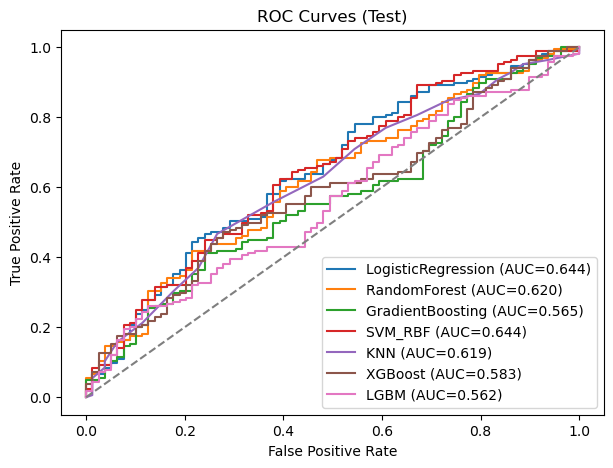

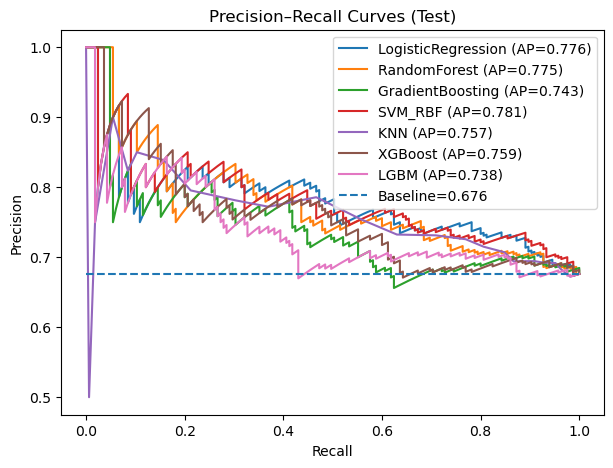


=== LogisticRegression — Feature Importance (Top 20) ===


,feature,importance,coef_signed
0,num__num_credit_cards,0.270939,0.270939
1,cat__gender_Male,0.099672,-0.099672
2,num__birth_year,0.095308,-0.095308
3,num__current_age,0.092842,0.092842
4,num__per_capita_income,0.039723,0.039723
5,num__total_debt,0.023602,0.023602
6,num__credit_score,0.019090,0.019090
7,num__retirement_age,0.017451,0.017451
8,num__yearly_income,0.001802,-0.001802


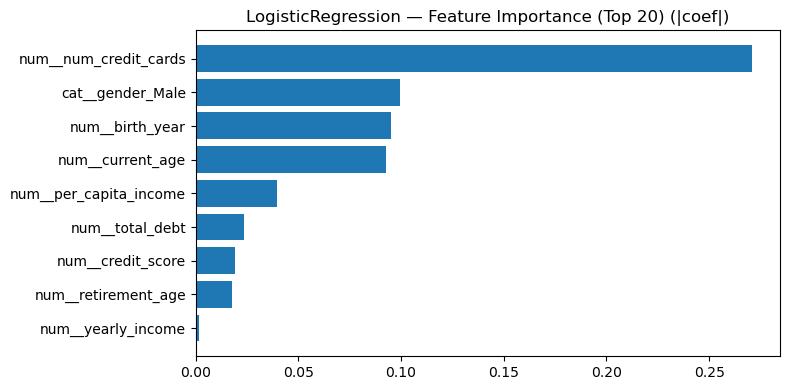


=== RandomForest — Feature Importance (Top 20) ===


,feature,importance
0,num__num_credit_cards,0.200935
1,num__current_age,0.157460
2,num__birth_year,0.153202
3,num__yearly_income,0.139664
4,num__credit_score,0.113732
5,num__per_capita_income,0.103311
6,num__total_debt,0.069594
7,num__retirement_age,0.044213
8,cat__gender_Male,0.017890


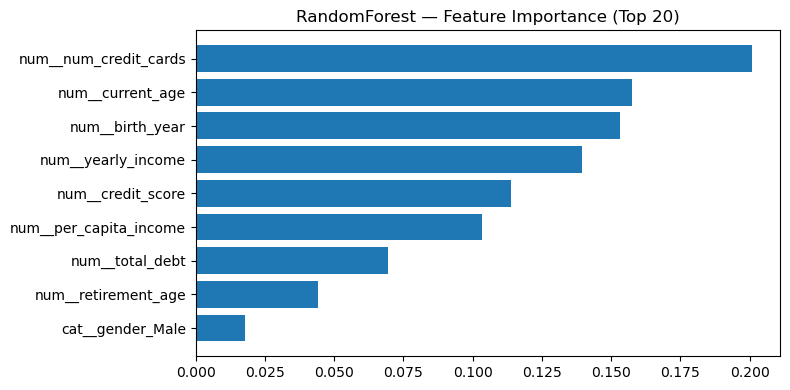


=== GradientBoosting — Feature Importance (Top 20) ===


,feature,importance
0,num__per_capita_income,0.168793
1,num__yearly_income,0.166472
2,num__credit_score,0.164632
3,num__total_debt,0.162384
4,num__birth_year,0.102584
5,num__num_credit_cards,0.093610
6,num__retirement_age,0.071099
7,num__current_age,0.055999
8,cat__gender_Male,0.014427


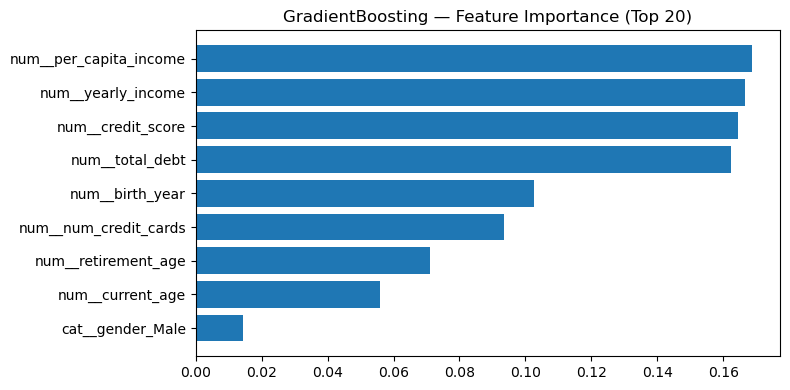


=== SVM_RBF — Feature Importance (Top 20) ===


,feature,importance
0,cat__gender_Male,0.053064
1,num__current_age,0.012603
2,num__birth_year,0.009912
3,num__retirement_age,0.005172
4,num__credit_score,0.004214
5,num__yearly_income,0.003962
6,num__total_debt,0.003245
7,num__per_capita_income,-0.001720
8,num__num_credit_cards,-0.006421


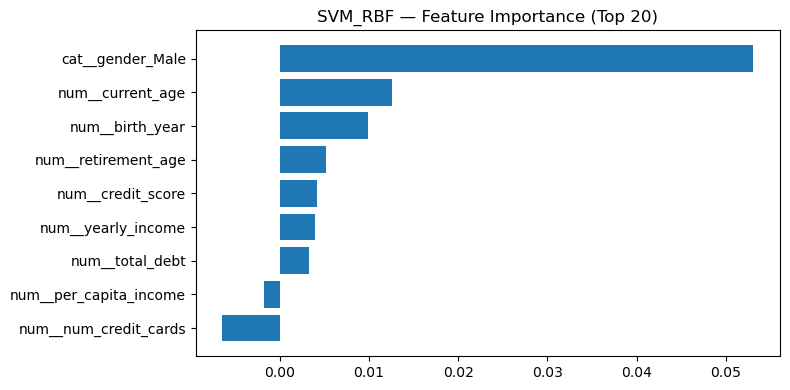


=== KNN — Feature Importance (Top 20) ===


,feature,importance
0,cat__gender_Male,0.049126
1,num__current_age,0.001781
2,num__birth_year,0.001069
3,num__yearly_income,-0.000016
4,num__credit_score,-0.000687
5,num__num_credit_cards,-0.004186
6,num__total_debt,-0.012087
7,num__per_capita_income,-0.015712
8,num__retirement_age,-0.022034


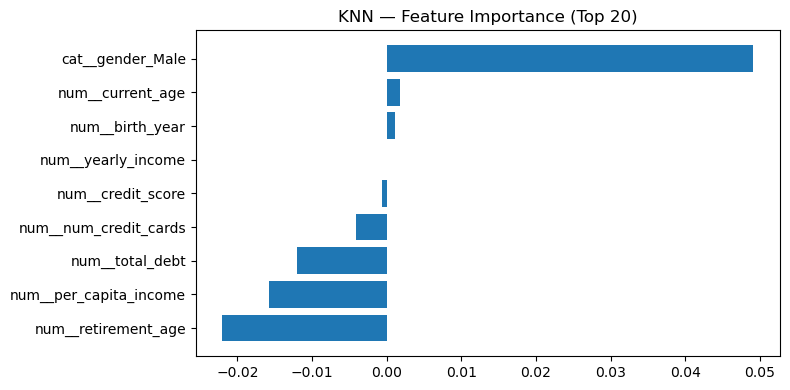


=== XGBoost — Feature Importance (Top 20) ===


,feature,importance
0,num__current_age,0.124967
1,num__num_credit_cards,0.120324
2,num__per_capita_income,0.119987
3,num__birth_year,0.112316
4,num__credit_score,0.106442
5,num__retirement_age,0.105389
6,cat__gender_Male,0.104223
7,num__yearly_income,0.103963
8,num__total_debt,0.102389


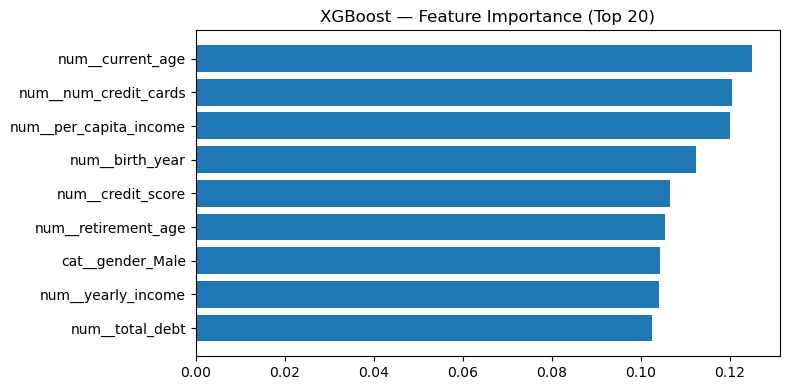


=== LGBM — Feature Importance (Top 20) ===


,feature,importance
0,num__total_debt,7204.0
1,num__credit_score,7026.0
2,num__per_capita_income,5952.0
3,num__yearly_income,5385.0
4,num__birth_year,3858.0
5,num__current_age,3013.0
6,num__retirement_age,2822.0
7,num__num_credit_cards,1832.0
8,cat__gender_Male,580.0


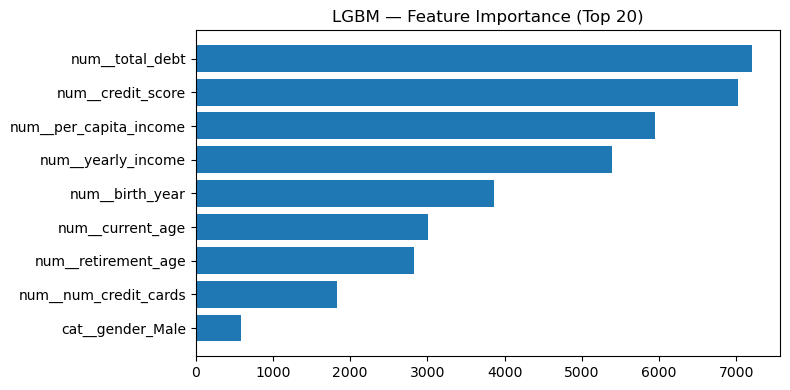

In [12]:
best_pipes, test_probas, rows = {}, {}, []

for name, (est, param_dists, n_iter) in models.items():
    pipe = Pipeline([("prep", preprocess), ("clf", est)])
    print(f'\n{name} 랜덤서치 시작')
    rs = RandomizedSearchCV(pipe, param_distributions=param_dists, n_iter=n_iter,
                            scoring="average_precision", cv=cv, n_jobs=-1, verbose=1,
                            refit=True, random_state=42)
    rs.fit(X_train, y_train)
    best = rs.best_estimator_
    best_pipes[name] = best

    y_pred = best.predict(X_test)
    if hasattr(best, "predict_proba"):
        proba = best.predict_proba(X_test)[:, 1]
    elif hasattr(best, "decision_function"):
        z = best.decision_function(X_test); proba = (z - z.min())/(z.max()-z.min() + 1e-9)
    else:
        proba = None
    test_probas[name] = proba

    row = {"model": name,
           "best_params": rs.best_params_,
           "cv_AP": rs.best_score_,
           "test_acc": accuracy_score(y_test, y_pred),
           "test_prec": precision_score(y_test, y_pred, zero_division=0),
           "test_rec": recall_score(y_test, y_pred, zero_division=0),
           "test_f1@0.5": f1_score(y_test, y_pred, zero_division=0),
           "test_ROC_AUC": np.nan if proba is None else roc_auc_score(y_test, proba),
           "test_PR_AUC":  np.nan if proba is None else average_precision_score(y_test, proba)}
    rows.append(row)
    print(f'{name} 랜덤서치 끝')
    
summary = pd.DataFrame(rows).sort_values(["test_PR_AUC","cv_AP"], ascending=[False, False]).reset_index(drop=True)
display(summary)

# ROC/PR 곡선 (확률 있는 모델만)
have_proba = {k:v for k,v in test_probas.items() if v is not None}
if have_proba:
    plt.figure(figsize=(7,5))
    for name, proba in have_proba.items():
        fpr, tpr, _ = roc_curve(y_test, proba)
        auc = roc_auc_score(y_test, proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
    plt.plot([0,1],[0,1], "--")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (Test)"); plt.legend(); plt.show()

    plt.figure(figsize=(7,5))
    base = float(np.mean(y_test))
    for name, proba in have_proba.items():
        p, r, _ = precision_recall_curve(y_test, proba)
        ap = average_precision_score(y_test, proba)
        plt.plot(r, p, label=f"{name} (AP={ap:.3f})")
    plt.hlines(base, 0, 1, linestyles="--", label=f"Baseline={base:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title("Precision–Recall Curves (Test)"); plt.legend(); plt.show()

# 피처 중요도(Top 20) — 트리계열/로지스틱만 간단 표시
for name, pipe in best_pipes.items():
    clf = pipe.named_steps["clf"]
    prep = pipe.named_steps["prep"]
    try:
        feat_names = prep.get_feature_names_out(X_train.columns)
    except Exception:
        try:
            n_after = prep.transform(X_train.iloc[:5]).shape[1]
        except Exception:
            n_after = getattr(clf, "n_features_in_", len(X_train.columns))
        feat_names = np.array([f"f{i}" for i in range(n_after)], dtype=object)

    imp_df = None
    if hasattr(clf, "feature_importances_"):
        vals = np.asarray(clf.feature_importances_, float)
        if len(vals) != len(feat_names):
            if len(vals) < len(feat_names):
                vals = np.pad(vals, (0, len(feat_names)-len(vals)))
            else:
                vals = vals[:len(feat_names)]
        imp_df = pd.DataFrame({"feature": feat_names, "importance": vals})

    elif hasattr(clf, "coef_"):
        coefs = np.ravel(clf.coef_)
        if len(coefs) != len(feat_names):
            if len(coefs) < len(feat_names):
                coefs = np.pad(coefs, (0, len(feat_names)-len(coefs)))
            else:
                coefs = coefs[:len(feat_names)]
        imp_df = pd.DataFrame({"feature": feat_names,
                               "importance": np.abs(coefs),
                               "coef_signed": coefs})

    else:
        r = permutation_importance(pipe, X_test, y_test, scoring="average_precision",
                                   n_repeats=5, random_state=42, n_jobs=-1)
        vals = r.importances_mean
        if len(vals) != len(feat_names):
            if len(vals) < len(feat_names):
                vals = np.pad(vals, (0, len(feat_names)-len(vals)))
            else:
                vals = vals[:len(feat_names)]
        imp_df = pd.DataFrame({"feature": feat_names, "importance": vals})

    if imp_df is None:
        print(f"\n[{name}] 중요도 지원 안 함(또는 생략).")
        continue

    top = (imp_df.sort_values("importance", ascending=False).head(20)).reset_index(drop=True)
    print(f"\n=== {name} — Feature Importance (Top 20) ===")
    display(top)

    # 수평 바차트
    plt.figure(figsize=(8, max(4, 0.4*len(top))))
    plt.barh(top.iloc[::-1]["feature"], top.iloc[::-1]["importance"])
    ttl = f"{name} — Feature Importance (Top 20)"
    if hasattr(clf, "coef_"): ttl += " (|coef|)"
    plt.title(ttl)
    plt.tight_layout(); plt.show()

In [13]:
summary_sorted = summary.drop(summary.columns[1], axis=1).sort_values(by=['test_f1@0.5', 'test_ROC_AUC'], ascending=[False, False]).reset_index(drop=True)
summary_sorted

,model,cv_AP,test_acc,test_prec,test_rec,test_f1@0.5,test_ROC_AUC,test_PR_AUC
0,KNN,0.745776,0.672131,0.682403,0.963636,0.798995,0.618642,0.756708
1,XGBoost,0.748886,0.676230,0.693694,0.933333,0.795866,0.582815,0.759284
2,GradientBoosting,0.754109,0.659836,0.700980,0.866667,0.775068,0.565094,0.742955
3,LGBM,0.732327,0.622951,0.706215,0.757576,0.730994,0.561642,0.738409
4,RandomForest,0.745915,0.598361,0.755725,0.600000,0.668919,0.620023,0.775420
5,LogisticRegression,0.764313,0.565574,0.752137,0.533333,0.624113,0.644112,0.775915
6,SVM_RBF,0.764782,0.569672,0.767857,0.521212,0.620939,0.643882,0.780652


In [14]:
best_model = summary_sorted['model'][0]
best_clf = best_pipes[best_model]['clf']

In [15]:
best_clf

,n_neighbors,60
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


---

### Bagging + OOB 

In [16]:
from sklearn.ensemble import BaggingClassifier

# 현재 X의 컬럼 순서를 기준으로 인덱스 맵 만들기
col_order = list(X.columns)
idx_num = [col_order.index(c) for c in num_cols]
idx_cat = [col_order.index(c) for c in cat_cols]

# 트리/배깅용: 스케일링 없이 숫자는 통과, 범주 원-핫
prep_tree = ColumnTransformer([("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), idx_cat),
                               ("num", "passthrough", idx_num)], remainder="drop")

# 선형/메타용: 숫자 스케일링 + 범주 원-핫
prep_lin = ColumnTransformer([("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), idx_cat), 
                              ("num", StandardScaler(), idx_num)], remainder="drop")

In [17]:
# 1. Bagging
est = Pipeline([
    ('prep', prep_lin),  # 데이터 전처리
    ('clf', best_clf)    # KNN 모델
])

# 배깅 모델
bag = BaggingClassifier(
    estimator=est,
    n_estimators=30,  # 사용할 모델의 개수
    bootstrap=True,    # 부트스트랩 샘플링
    oob_score=True,    # OOB 점수 계산
    n_jobs=-1,         # 멀티코어 사용
    random_state=42,
)

# KNN 배깅 모델 학습
bag.fit(X, y)

# OOB 점수 확인
print(f"OOB Score:", bag.oob_score_)

OOB Score: 0.6710418375717802


In [18]:
def tune_threshold(y_true, proba, metric=None):
    grid = np.linspace(0.05, 0.95, 181)
    best_thr, best = 0.5, -1
    for thr in grid:
        pred = (proba >= thr).astype(int)
        
        # metric으로 선택한 값에 따라 score 계산
        if 'f1':
            val = f1_score(y_true, pred)
        else:
            val = f1_score(y_true, pred, average=metric)  
        
        if val > best:
            best_thr, best = thr, val

    return best_thr, best, 

In [19]:
def get_oob_classification_reports(bag):
    oob_df = bag.oob_decision_function_
    oob_proba = oob_df[:, 1] if oob_df.ndim == 2 and oob_df.shape[1] == 2 else oob_df.ravel()
    
    # (1) 임계값 0.5
    y_pred_05 = (oob_proba >= 0.5).astype(int)
    print("=== OOB classification_report @ threshold = 0.50 ===")
    print(classification_report(y, y_pred_05, digits=4))
    
    # (2) OOB에서 F1 기준 최적 임계값
    thr_best, f1_best = tune_threshold(y, oob_proba, metric='f1')
    y_pred_best = (oob_proba >= thr_best).astype(int)
    print(f"\n=== OOB classification_report @ best F1 threshold = {thr_best:.3f} ===")
    print(classification_report(y, y_pred_best, digits=4))

    return oob_proba, thr_best, y_pred_05, y_pred_best

In [20]:
oob_proba, thr_best, y_pred_05, y_pred_best = get_oob_classification_reports(bag)

=== OOB classification_report @ threshold = 0.50 ===
              precision    recall  f1-score   support

           0     0.4688    0.0378    0.0699       397
           1     0.6782    0.9793    0.8014       822

    accuracy                         0.6727      1219
   macro avg     0.5735    0.5086    0.4357      1219
weighted avg     0.6100    0.6727    0.5632      1219


=== OOB classification_report @ best F1 threshold = 0.470 ===
              precision    recall  f1-score   support

           0     0.6000    0.0151    0.0295       397
           1     0.6766    0.9951    0.8055       822

    accuracy                         0.6760      1219
   macro avg     0.6383    0.5051    0.4175      1219
weighted avg     0.6516    0.6760    0.5528      1219



In [21]:
def precision_at_k(y_true, proba, k=0.03):
    y_true = np.asarray(y_true).reshape(-1)
    n = max(1, int(len(proba)*k))
    idx = np.argsort(-proba)[:n]
    return (y_true[idx] == 1).mean()

def recall_at_k(y_true, proba, k=0.03):
    y_true = np.asarray(y_true).reshape(-1)
    n = max(1, int(len(proba)*k))
    idx = np.argsort(-proba)[:n]
    return y_true[idx].sum() / y_true.sum()

def show_oob_evaluation(oob_proba, thr_best, clf_name):
    # ROC Curve
    plt.figure(figsize=(7,5))
    fpr, tpr, _ = roc_curve(y, oob_proba)
    auc = roc_auc_score(y, oob_proba)
    plt.plot(fpr, tpr, label=f"Bagging({clf_name}) OOB (AUC={auc:.3f})")
    plt.plot([0,1],[0,1], "--")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (OOB)")
    plt.legend(); plt.show()
    
    # PR Curve
    plt.figure(figsize=(7,5))
    prec, rec, _ = precision_recall_curve(y, oob_proba)
    ap = average_precision_score(y, oob_proba)
    baseline = float(np.mean(y))
    plt.plot(rec, prec, label=f"OOB (AP={ap:.3f})")
    plt.hlines(baseline, 0, 1, linestyles="--", label=f"Baseline={baseline:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title("Precision–Recall Curve (OOB)")
    plt.legend(); plt.show()
    
    # Calibration Curve (분위수 10 bins)
    def calibration_curve_quantile(y_true, proba, n_bins=10):
        qs = np.linspace(0,1,n_bins+1)
        edges = np.quantile(proba, qs)
        edges = np.unique(edges)
        bins = np.digitize(proba, edges[1:-1], right=True)
        mean_pred = []
        frac_pos = []
        for b in range(bins.min(), bins.max()+1):
            mask = (bins == b)
            if mask.sum() == 0: 
                continue
            mean_pred.append(proba[mask].mean())
            frac_pos.append(y[mask].mean())
        return np.array(mean_pred), np.array(frac_pos)
    
    mp, fp = calibration_curve_quantile(np.asarray(y), oob_proba, n_bins=10)
    plt.figure(figsize=(7,5))
    plt.plot(mp, fp, marker="o", label="OOB")
    plt.plot([0,1],[0,1], "--")
    plt.xlabel("Mean predicted probability"); plt.ylabel("Fraction of positives")
    plt.title("Calibration Curve (OOB)")
    plt.legend(); plt.show()
    
    # 임계값 스윕(Precision/Recall/F1)
    thrs = np.linspace(0.05, 0.95, 61)
    precisions, recalls, f1_scores = [], [], []
    y_arr = np.asarray(y).reshape(-1)
    for thr in thrs:
        y_pedict = (oob_proba >= thr).astype(int) # oob_proba (예측 확률) > t면 1, 아니면 0으로 변환
        tp = ((y_pedict == 1)&(y_arr == 1)).sum()
        fp_ = ((y_pedict == 1)&(y_arr == 0)).sum()
        fn = ((y_pedict == 0)&(y_arr == 1)).sum()
        precision = tp / (tp + fp_ + 1e-9)
        recall = tp / (tp + fn + 1e-9)
        f1_score = 2 * precision * recall / (precision + recall + 1e-9)
        precisions.append(precision); recalls.append(recall); f1_scores.append(f1_score)
    
    plt.figure(figsize=(8,5))
    plt.plot(thrs, precisions, label="Precision")
    plt.plot(thrs, recalls, label="Recall")
    plt.plot(thrs, f1_scores, label="F1_score")
    plt.axvline(0.5, ls="--", label="thr=0.50", color='k')
    plt.axvline(thr_best, ls="--", label=f"best F1 thr={thr_best:.3f}", color='c')
    plt.xlabel("Threshold"); plt.ylabel("Score")
    plt.title("Threshold Sweep (OOB)")
    plt.legend(); plt.show()
    
    # Confusion Matrix (thr=0.50 vs best F1 thr)
    def plot_cm(y, y_pred, title):
        cm = confusion_matrix(y, y_pred)
        plt.figure(figsize=(4.2,3.6))
        plt.imshow(cm, cmap="Blues")
        for i in range(2):
            for j in range(2):
                plt.text(j, i, cm[i,j], ha="center", va="center")
        plt.xticks([0,1], ["Pred 0","Pred 1"])
        plt.yticks([0,1], ["True 0","True 1"])
        plt.title(title); plt.colorbar(); plt.tight_layout(); plt.show()
    
    plot_cm(y, y_pred_05, "Confusion Matrix @ thr=0.50 (OOB)")
    plot_cm(y, y_pred_best, f"Confusion Matrix @ best F1 thr={thr_best:.3f} (OOB)")
    
    # 6) 운영지표: Precision@K & Recall@K (K=1%, 3%, 5%)
    for k in [0.01, 0.03, 0.05]:
        print(f"Top{k*100:.0f}% Precision :", round(precision_at_k(y, oob_proba, k), 4),
              " | Recall :", round(recall_at_k(y, oob_proba, k), 4))

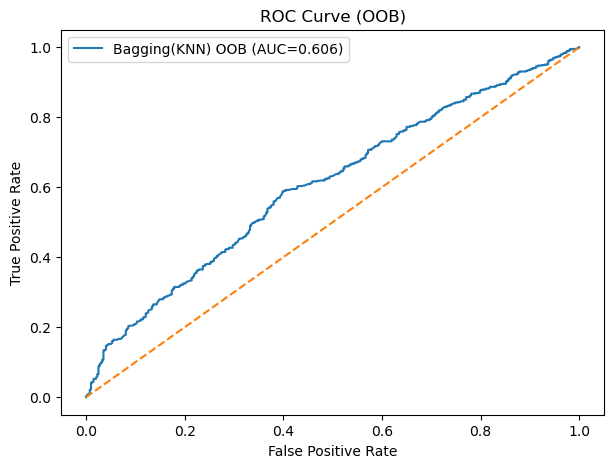

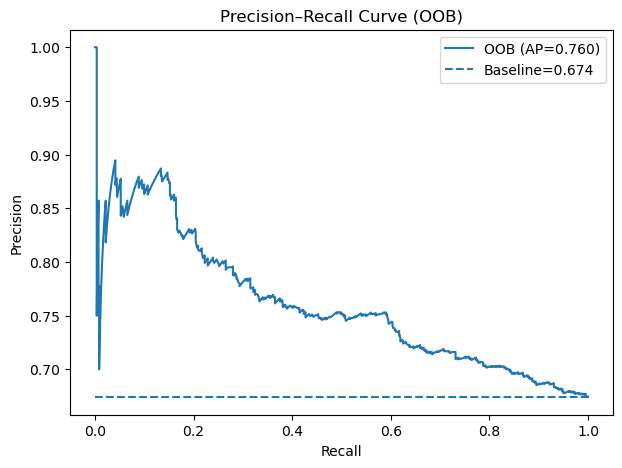

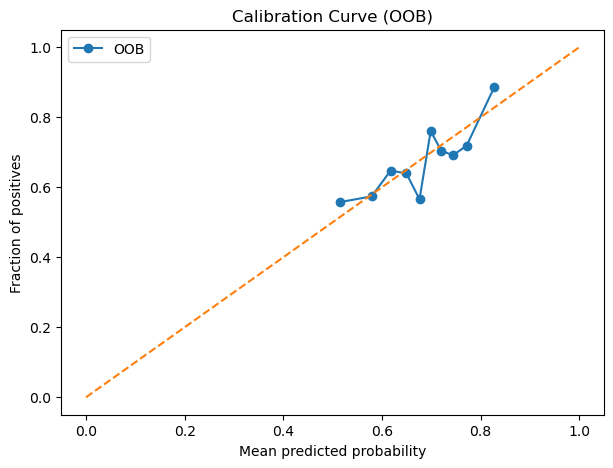

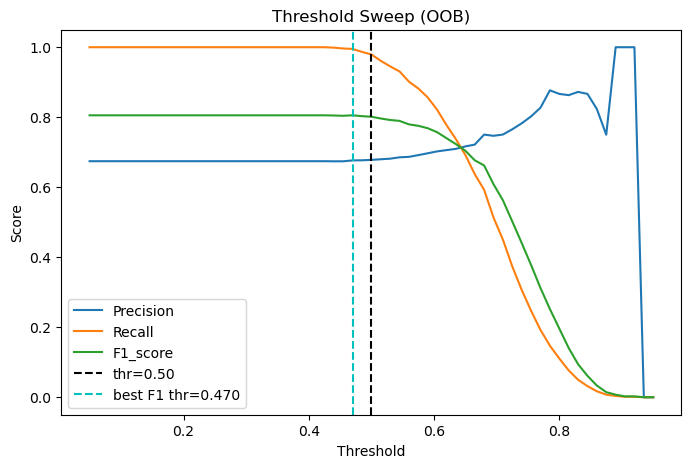

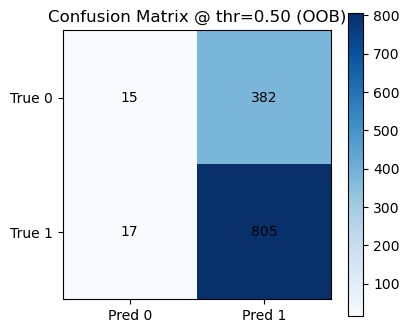

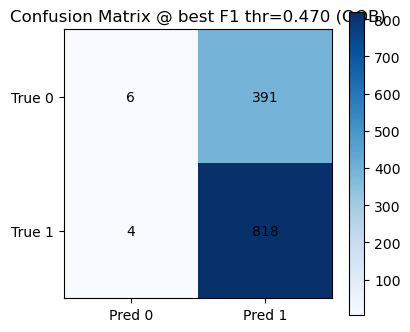

Top1% Precision : 0.75  | Recall : 0.0109
Top3% Precision : 0.8889  | Recall : 0.0389
Top5% Precision : 0.85  | Recall : 0.062


In [22]:
show_oob_evaluation(oob_proba, thr_best, best_model)